In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 
import argparse
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
import Torch_Pruning.torch_pruning as tp

In [3]:
class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [34]:
def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.4, 0.2, 0.1, 0.05, 0.1, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
    conv_id = 0
    for m in model.features:
        if isinstance( m, torch.nn.Conv2d ):
            prune_conv( m, block_prune_probs[conv_id] )
            conv_id += 1
    return model

In [35]:
def get_dataloader():
    train_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=True, transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), download=True),batch_size=256, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ]),download=True),batch_size=256, num_workers=2)
    return train_loader, test_loader

In [36]:
def eval(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

In [37]:
def train_model(model, train_loader, test_loader, epochs, round_num):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 70, 0.1)
    model.to(device)
    acc_s = []
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
        model.eval()
        acc = eval(model, test_loader)
        acc_s.append(acc)
        if best_acc<acc:
            torch.save( model, 'vgg16-round%d.pth'%(round_num) )
            best_acc=acc
        scheduler.step()
    return best_acc, np.mean(acc_s)

In [38]:
train_loader, test_loader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [39]:
model = VGG('vgg16', 'CIFAR10')

In [40]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 15.0M


In [41]:
model_dict = {
    'params': [],
    'summary': [],
    'best_acc': [],
    'mean_acc': [],
    'out_channels': [],
    'size': [],
    'macs_params': []
}

In [42]:
# New
for i in range(5):
    print(f'--- Round {i} ---')
    if i > 0:
        model = prune_model(model)
    params = sum([np.prod(p.size()) for p in model.parameters()])
    model_dict['params'].append(params/1e6)
    model_dict['summary'].append(model)
    best_acc, mean_acc = train_model(model, train_loader, test_loader, 100 if i == 0 else 30, i)
    model_dict['best_acc'].append(best_acc)
    model_dict['mean_acc'].append(mean_acc)
    model_dict['macs_params'].append(tp.utils.count_macs_and_params(model.cpu(), (1,3,32,32)))
    
    size = os.path.getsize('vgg16-round{x}.pth'.format(x=i)) / (1024 * 1024)
    model_dict['size'].append(size)
    print("Number of Parameters: %.1f M"%(params/1e6))
    print(f"Model Size: {size:.3f} MB")
    
    out_ch = []
    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            out_ch.append(layer.weight.data.cpu().numpy().shape[0])
    model_dict['out_channels'].append(out_ch)

--- Round 0 ---
Number of Parameters: 15.0 M
Model Size: 57.178 MB
--- Round 1 ---
Number of Parameters: 3.1 M
Model Size: 11.882 MB
--- Round 2 ---
Number of Parameters: 0.9 M
Model Size: 3.578 MB
--- Round 3 ---
Number of Parameters: 0.5 M
Model Size: 1.787 MB
--- Round 4 ---
Number of Parameters: 0.3 M
Model Size: 1.243 MB


In [12]:
for i in range(5):
    print(f'--- Round {i} ---')
    if i > 0:
        model = prune_model(model)
    params = sum([np.prod(p.size()) for p in model.parameters()])
    model_dict['params'].append(params/1e6)
    model_dict['summary'].append(model)
    best_acc, mean_acc = train_model(model, train_loader, test_loader, 100 if i == 0 else 30, i)
    model_dict['best_acc'].append(best_acc)
    model_dict['mean_acc'].append(mean_acc)
    model_dict['macs_params'].append(tp.utils.count_macs_and_params(model.cpu(), (1,3,32,32)))
    
    size = os.path.getsize('vgg16-round{x}.pth'.format(x=i)) / (1024 * 1024)
    model_dict['size'].append(size)
    print("Number of Parameters: %.1f M"%(params/1e6))
    print(f"Model Size: {size:.3f} MB")
    
    out_ch = []
    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            out_ch.append(layer.weight.data.cpu().numpy().shape[0])
    model_dict['out_channels'].append(out_ch)

--- Round 0 ---
Number of Parameters: 15.0 M
Model Size: 57.178 MB
--- Round 1 ---
Number of Parameters: 1.4 M
Model Size: 5.354 MB
--- Round 2 ---
Number of Parameters: 0.5 M
Model Size: 1.992 MB
--- Round 3 ---
Number of Parameters: 0.4 M
Model Size: 1.394 MB
--- Round 4 ---
Number of Parameters: 0.3 M
Model Size: 1.117 MB


In [43]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(9, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(86, 106, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(106, 170, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(170, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [46]:
model_dict

{'params': [14.983498, 3.109124, 0.932431, 0.462918, 0.320376],
 'summary': [VGG(
    (features): Sequential(
      (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(9, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(28, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(86, 106, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(106, 170, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(170, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(

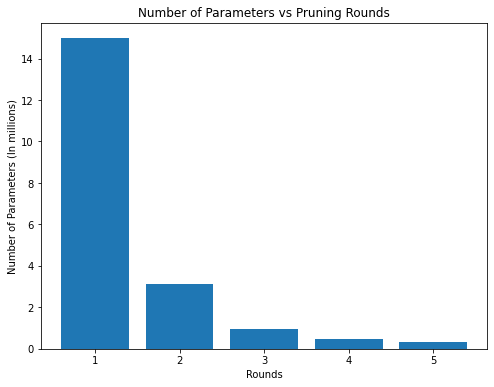

In [47]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), model_dict['params'])
plt.xlabel('Rounds')
plt.ylabel('Number of Parameters (In millions)')
plt.title('Number of Parameters vs Pruning Rounds')
plt.show()

In [48]:
for i, params in enumerate(model_dict['params']):
    print(f'Round {i+1}: Parameters = {params :.2f} M')

Round 1: Parameters = 14.98 M
Round 2: Parameters = 3.11 M
Round 3: Parameters = 0.93 M
Round 4: Parameters = 0.46 M
Round 5: Parameters = 0.32 M


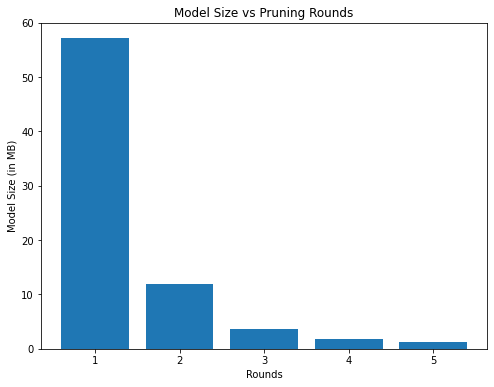

In [49]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), model_dict['size'])
plt.xlabel('Rounds')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size vs Pruning Rounds')
plt.show()

In [50]:
for i, sz in enumerate(model_dict['size']):
    print(f'Round {i+1}: Model Size = {sz :.2f} MB')

Round 1: Model Size = 57.18 MB
Round 2: Model Size = 11.88 MB
Round 3: Model Size = 3.58 MB
Round 4: Model Size = 1.79 MB
Round 5: Model Size = 1.24 MB


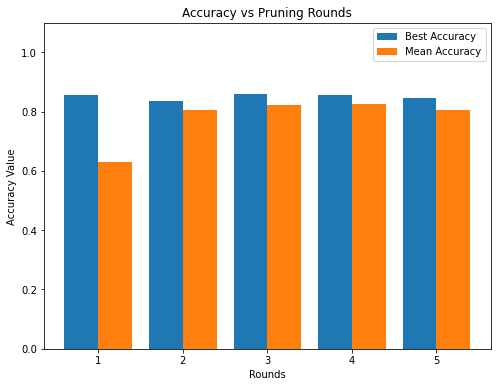

In [51]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6) - 0.2, model_dict['best_acc'], 0.4, label='Best Accuracy')
plt.bar(np.arange(1, 6) + 0.2, model_dict['mean_acc'], 0.4, label='Mean Accuracy')
plt.ylim(0.0, 1.1)
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

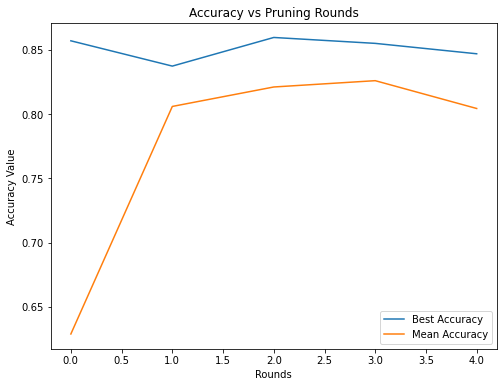

In [52]:
plt.figure(figsize=(8,6))
plt.plot(model_dict['best_acc'], label='Best Accuracy')
plt.plot(model_dict['mean_acc'], label='Mean Accuracy')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

In [53]:
for i, acc in enumerate(model_dict['best_acc']):
    print(f'Round {i+1}: Best Test Accuracy = {acc :.2%}')

Round 1: Best Test Accuracy = 85.71%
Round 2: Best Test Accuracy = 83.74%
Round 3: Best Test Accuracy = 85.97%
Round 4: Best Test Accuracy = 85.51%
Round 5: Best Test Accuracy = 84.70%


In [54]:
for i, acc in enumerate(model_dict['mean_acc']):
    print(f'Round {i+1}: Mean Test Accuracy = {acc :.2%}')

Round 1: Mean Test Accuracy = 62.88%
Round 2: Mean Test Accuracy = 80.60%
Round 3: Mean Test Accuracy = 82.11%
Round 4: Mean Test Accuracy = 82.61%
Round 5: Mean Test Accuracy = 80.44%


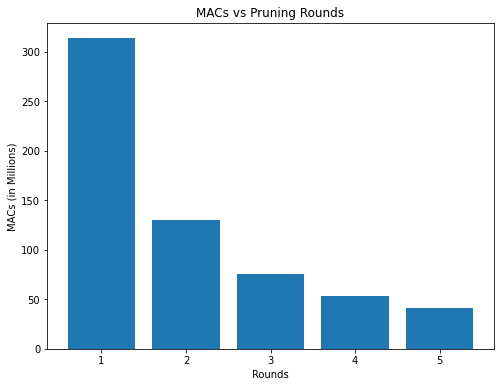

In [55]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), [a[0]/1e6 for a in model_dict['macs_params']])
plt.xlabel('Rounds')
plt.ylabel('MACs (in Millions)')
plt.title('MACs vs Pruning Rounds')
plt.show()

In [56]:
for i, tup in enumerate(model_dict['macs_params']):
    print(f'Round {i+1}: MACs = {tup[0]/1e6 :.2f}M, Parameters = {tup[1]/1e6 :.2f}M')

Round 1: MACs = 313.47M, Parameters = 14.98M
Round 2: MACs = 129.51M, Parameters = 3.11M
Round 3: MACs = 75.57M, Parameters = 0.93M
Round 4: MACs = 53.53M, Parameters = 0.46M
Round 5: MACs = 41.34M, Parameters = 0.32M


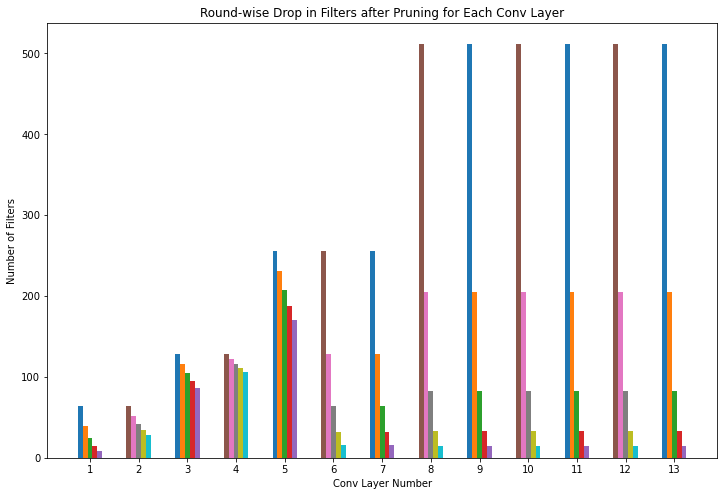

In [57]:
X = np.arange(1, 14)
plt.figure(figsize=(12, 8))

deltas = [-0.2, -0.1, 0, 0.1, 0.2]
for i in range(len(model_dict['out_channels'][0])):
    x = [a[i] for a in model_dict['out_channels']]
    for j in range(len(deltas)):
        plt.bar(X[i] + deltas[j], x[j], 0.1)

plt.xticks(X)
plt.xlabel('Conv Layer Number')
plt.ylabel('Number of Filters')
plt.title('Round-wise Drop in Filters after Pruning for Each Conv Layer')
plt.show()

In [58]:
cols = [f'Conv Layer {i+1}' for i in range(len(model_dict['out_channels'][0]))]
idxs = [f'Round {i+1}' for i in range(len(model_dict['out_channels']))]

In [59]:
pd.DataFrame(model_dict['out_channels'], columns = cols, index=idxs).transpose().head(20)

,Round 1,Round 2,Round 3,Round 4,Round 5
Conv Layer 1,64,39,24,15,9
Conv Layer 2,64,52,42,34,28
Conv Layer 3,128,116,105,95,86
Conv Layer 4,128,122,116,111,106
Conv Layer 5,256,231,208,188,170
Conv Layer 6,256,128,64,32,16
Conv Layer 7,256,128,64,32,16
Conv Layer 8,512,205,82,33,14
Conv Layer 9,512,205,82,33,14
Conv Layer 10,512,205,82,33,14


In [60]:
model_dict['out_channels']

[[64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512],
 [39, 52, 116, 122, 231, 128, 128, 205, 205, 205, 205, 205, 205],
 [24, 42, 105, 116, 208, 64, 64, 82, 82, 82, 82, 82, 82],
 [15, 34, 95, 111, 188, 32, 32, 33, 33, 33, 33, 33, 33],
 [9, 28, 86, 106, 170, 16, 16, 14, 14, 14, 14, 14, 14]]

In [61]:
for i in range(len(model_dict['out_channels'][0])):
    filters = [a[i] for a in model_dict['out_channels']]
    print(f'Number of Filters in Layer {i+1} in each round: ', end='')
    for x, j in enumerate(filters):
        print(str(j), end='')
        if x != len(model_dict['out_channels']) - 1:
            print(" => ", end='')
    print()

Number of Filters in Layer 1 in each round: 64 => 39 => 24 => 15 => 9
Number of Filters in Layer 2 in each round: 64 => 52 => 42 => 34 => 28
Number of Filters in Layer 3 in each round: 128 => 116 => 105 => 95 => 86
Number of Filters in Layer 4 in each round: 128 => 122 => 116 => 111 => 106
Number of Filters in Layer 5 in each round: 256 => 231 => 208 => 188 => 170
Number of Filters in Layer 6 in each round: 256 => 128 => 64 => 32 => 16
Number of Filters in Layer 7 in each round: 256 => 128 => 64 => 32 => 16
Number of Filters in Layer 8 in each round: 512 => 205 => 82 => 33 => 14
Number of Filters in Layer 9 in each round: 512 => 205 => 82 => 33 => 14
Number of Filters in Layer 10 in each round: 512 => 205 => 82 => 33 => 14
Number of Filters in Layer 11 in each round: 512 => 205 => 82 => 33 => 14
Number of Filters in Layer 12 in each round: 512 => 205 => 82 => 33 => 14
Number of Filters in Layer 13 in each round: 512 => 205 => 82 => 33 => 14
